<a href="https://colab.research.google.com/github/boomiikas/Potato-Disease-Leaves-Detection/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"boomikas27","key":"67cf8c85095f91efaaa364172c23d667"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s plantdisease

ref                                       title                              size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------  --------------------------  -----------  --------------------------  -------------  ---------  ---------------  
mummidi31/plantdisease                    Plantdisease                      12215  2020-12-14 06:53:29.700000             29          4  0.125            
ly9802/plantdisease                       PlantDisease                  855079835  2021-12-10 05:52:35.963000             35          1  0.23529412       
minhaz027/plantdisease                    Plantdisease                  153905669  2021-04-25 20:53:24.067000             25          1  0.0              
sayanroy058/plantdisease                  PlantDisease                  934938040  2024-07-23 18:41:45.293000              5          0  0.25             
ahmedsharaf09/plantdiseasegp              PlantDisease(GP)            

In [ ]:
# 🔹 1. Download PlantVillage dataset from Kaggle
!kaggle datasets download -d emmarex/plantdisease -p /content/
!unzip -q /content/plantdisease.zip -d /content/plant_disease

# 🔹 2. Keep only Potato___Early_blight, Potato___Late_blight, Potato___healthy
import os, shutil

base_dir = "/content/plant_disease/PlantVillage"
save_dir = "/content/potato_dataset"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

classes_to_keep = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]

for cls in classes_to_keep:
    src = os.path.join(base_dir, cls)
    dst = os.path.join(save_dir, cls)
    if os.path.exists(dst):
        shutil.rmtree(dst)
    shutil.copytree(src, dst)

print("✅ Dataset ready at:", save_dir)
print("Classes inside:", os.listdir(save_dir))
for cls in os.listdir(save_dir):
    print(f"{cls}: {len(os.listdir(os.path.join(save_dir, cls)))} images")


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 96% 633M/658M [00:03<00:00, 236MB/s]
100% 658M/658M [00:03<00:00, 198MB/s]
✅ Dataset ready at: /content/potato_dataset
Classes inside: ['Potato___healthy', 'Potato___Early_blight', 'Potato___Late_blight']
Potato___healthy: 152 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images


In [ ]:
!pip install split-folders tensorflow matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
import os

dataset_dir = "/content/potato_dataset"
train_dir = "/content/potato_dataset_split/train"
val_dir = "/content/potato_dataset_split/val"
test_dir = "/content/potato_dataset_split/test"

import splitfolders

splitfolders.ratio(dataset_dir, output="/content/potato_dataset_split",seed=42, ratio=(0.7, 0.2, 0.1))

IMG_SIZE = (224, 224)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")  # 3 classes
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_potato_cnn.h5",
    save_best_only=True,
    verbose=1
)

EPOCHS = 32
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.2f}")


model.save("potato_cnn_final.h5")


Copying files: 2152 files [00:00, 5714.30 files/s]

Found 1506 images belonging to 3 classes.


Found 430 images belonging to 3 classes.
Found 216 images belonging to 3 classes.
Epoch 1/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.4746 - loss: 1.7028
Epoch 1: val_loss improved from inf to 0.77820, saving model to best_potato_cnn.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4752 - loss: 1.6848 - val_accuracy: 0.7628 - val_loss: 0.7782
Epoch 2/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.6674 - loss: 0.7618
Epoch 2: val_loss improved from 0.77820 to 0.62254, saving model to best_potato_cnn.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 780ms/step - accuracy: 0.6689 - loss: 0.7598 - val_accuracy: 0.7256 - val_loss: 0.6225
Epoch 3/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.7698 - loss: 0.5898
Epoch 3: val_loss improved from 0.62254 to 0.41517, saving model to best_potato_cnn.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 814ms/step - accuracy: 0.7700 - loss: 0.5897 - val_accuracy: 0.8279 - val_loss: 0.4152
Epoch 4/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.8041 - loss: 0.5135
Epoch 4: val_loss improved from 0.41517 to 0.27888, saving model to best_potato_cnn.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 762ms/step - accuracy: 0.8051 - loss: 0.5115 - val_accuracy: 0.8767 - val_loss: 0.2789
Epoch 5/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.7685 - loss: 0.5471
Epoch 5: val_loss did not improve from 0.27888
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 793ms/step - accuracy: 0.7677 - loss: 0.5488 - val_accuracy: 0.7442 - val_loss: 0.7301
Epoch 6/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.8493 - loss: 0.4230
Epoch 6: val_loss did not improve from 0.27888
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 787ms/step - accuracy: 0.8498 - loss: 0.4208 - val_accuracy: 0.7605 - val_loss: 0.6055
Epoch 7/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.8518 - loss: 0.3450
Epoch 7: val_loss improved from 0.27888 to 0.19677, saving model to best_potato_cnn.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 761ms/step - accuracy: 0.8520 - loss: 0.3442 - val_accuracy: 0.9395 - val_loss: 0.1968
Epoch 8/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.8957 - loss: 0.2596
Epoch 8: val_loss did not improve from 0.19677
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 779ms/step - accuracy: 0.8962 - loss: 0.2593 - val_accuracy: 0.8814 - val_loss: 0.3078
Epoch 9/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.9037 - loss: 0.2386
Epoch 9: val_loss did not improve from 0.19677
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 751ms/step - accuracy: 0.9038 - loss: 0.2389 - val_accuracy: 0.8349 - val_loss: 0.3684
Epoch 10/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.9497 - loss: 0.1808
Epoch 10: val_loss did not improve from 0.19677
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 795ms/step - accuracy: 0.9492 - loss: 0.1811 - val_accuracy: 0.9000 - val_loss: 0.2395
Epoch 11/32
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.9410 - loss: 0.1701
Epoch 11: val_loss did not improve from 

Test Accuracy: 0.95


In [ ]:
print("Training Accuracy:", history.history["accuracy"][-1])
print("Validation Accuracy:", history.history["val_accuracy"][-1])

Training Accuracy: 0.9548472762107849
Validation Accuracy: 0.895348846912384


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
Classification Report:

                       precision    recall  f1-score   support

Potato___Early_blight       0.97      0.99      0.98       100
 Potato___Late_blight       0.93      0.96      0.95       100
     Potato___healthy       0.91      0.62      0.74        16

             accuracy                           0.95       216
            macro avg       0.94      0.86      0.89       216
         weighted avg       0.95      0.95      0.95       216



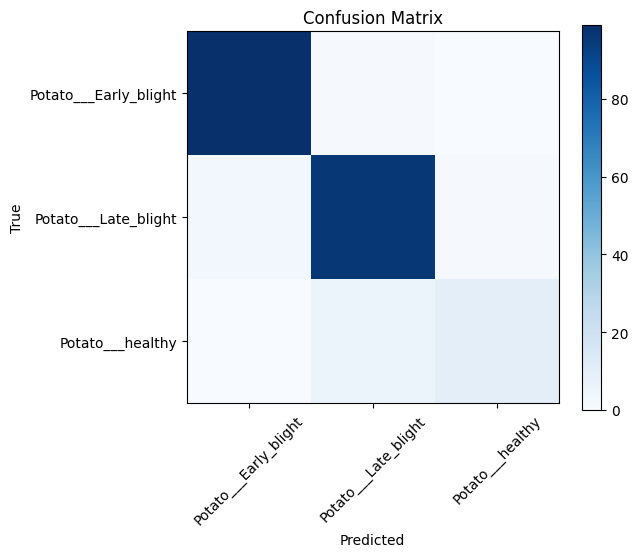

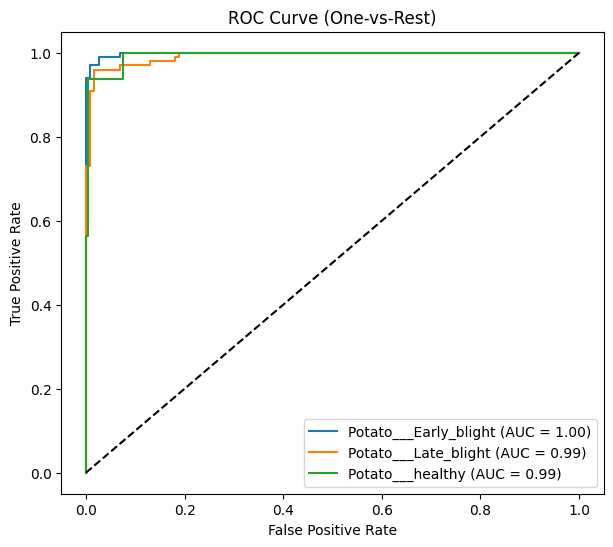

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
plt.yticks(np.arange(len(class_labels)), class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=list(range(len(class_labels))))
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(7,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()
